We'll write a simplifier a la Luckasz

In [3]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import SVG, display
from cirq.contrib.svg import SVGCircuit


class Solver:
    def __init__(self, n_qubits=3, qlr=0.01, qepochs=100,verbose=0, g=1, J=0, noises={}):

        """"solver with n**2 possible actions: n(n-1) CNOTS + n 1-qubit unitary"""
        self.n_qubits = n_qubits
        self.qubits = cirq.GridQubit.rect(1, n_qubits)
        self.lower_bound_Eg = -2*self.n_qubits
        
        self.qlr = qlr
        self.qepochs=qepochs
        self.verbose=verbose


        self.indexed_cnots = {}
        self.cnots_index = {}
        count = 0
        for control in range(self.n_qubits):
            for target in range(self.n_qubits):
                if control != target:
                    self.indexed_cnots[str(count)] = [control, target]
                    self.cnots_index[str([control,target])] = count
                    count += 1
        self.number_of_cnots = len(self.indexed_cnots)
        
        self.final_params = []
        self.parametrized_unitary = [cirq.rz, cirq.rx, cirq.rz]
        self.noises=noises
        self.noise_level = self.noises["depolarizing"]
        
        self.observable=self.ising_obs(g=g, J=J)
        self.resolver = {}
        self.new_resolver = {} #this temporarly stores initialized parameters of identity resolution
        self.lowest_energy_found = -.1
        self.best_circuit_found = []
        self.best_resolver_found = {}
        
        
    def ising_obs(self, g=1, J=0):
        # -  \Gamma/2 \sum_i Z_i - J/2 \sum_{i} X_i X_{i+1}    (S_i = \Sigma_i/2; ej S_z = Z/2, S_x = X/2)
        ### analytic solution https://sci-hub.tw/https://www.sciencedirect.com/science/article/abs/pii/0003491670902708?via%3Dihub
        observable = [-float(0.5*g)*cirq.Z.on(q) for q in self.qubits] 
        for q in range(len(self.qubits)):
            observable.append(-float(0.5*J)*cirq.X.on(self.qubits[q])*cirq.X.on(self.qubits[(q+1)%len(self.qubits)]))
        #### E_0 = -\Gamma/2 \sum_k \Lambda_k , with \Lambda_k = \sqrt{ 1 + \lambda^{2}  + 2 \lambda \cos(k)}; 
        ### k = -N/2, ... , 0 ,... N/2-1 if N even
        #### k = -(N-1)/2, ... 0 , ... (N-1)/2 if N odd
        if self.n_qubits%2 == 0:
            val = -self.n_qubits/2
        else:
            val = -(self.n_qubits-1)/2
        values_q = []
        for k in range(2*self.n_qubits):
            values_q.append(val)
            val += 1/2
        ###soething wrong here.
        self.ground_energy = -(0.5*g)*np.sum(np.sqrt([1+(J/(2*g))**2 - (np.cos(2*np.pi*q/self.n_qubits)*(J/g)) for q in values_q]))
        return observable
        
    def index_meaning(self,index):
        if index<self.number_of_cnots:
            print("cnot: ",self.indexed_cnots[str(index)])
            return
        else:
            print("1-qubit unitary on: ",(index-self.number_of_cnots)%self.n_qubits)
            return

    def append_to_circuit(self, ind, circuit, params, new_index=False):
        """
        appends to circuit the index of the gate;
        and if one_hot_gate implies a rotation,
        appends to params a symbol
        """
        if ind < self.number_of_cnots:
            control, target = self.indexed_cnots[str(ind)]
            circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            return circuit, params
        else:
            qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
            for par, gate in zip(range(3),self.parametrized_unitary):
                new_param = "th_"+str(len(params))
                params.append(new_param)
                circuit.append(gate(sympy.Symbol(new_param)).on(qubit))
            return circuit, params
        
    def give_circuit(self, lista,one_hot=False):
        circuit, symbols = [], []
        for k in lista:
            circuit, symbols = self.append_to_circuit(k,circuit,symbols)
        circuit = cirq.Circuit(circuit)
        return circuit, symbols
    
    
    def resolution_2cnots(self, q1, q2):
        u1 = self.number_of_cnots + q1
        u2 = self.number_of_cnots + q2
        cnot = self.cnots_index[str([q1,q2])]
        return [cnot, u1, u2, cnot]
    
    def resolution_1qubit(self, q):
        u1 = self.number_of_cnots + q
        return [u1]
        

    def dressed_cnot(self,q1,q2):
        u1 = self.number_of_cnots + q1
        u2 = self.number_of_cnots + q2
        cnot = self.cnots_index[str([q1,q2])]
        u3 = self.number_of_cnots + q1
        u4 = self.number_of_cnots + q2
        return [u1,u2,cnot,u3,u4]
    
    def dressed_ansatz(self, layers=1):
        c=[]
        for layer in range(layers):
            qubits = list(range(self.n_qubits))
            qdeph = qubits[layers:]
            for q in qubits[:layers]:
                qdeph.append(q)
            for ind1, ind2 in zip(qubits,qdeph):
                for k in self.dressed_cnot(ind1,ind2):
                    c.append(k)
        return c


    def prepare_circuit_insertion(self,gates_index, block_to_insert, index_insertion):
        """gates_index is a vector with integer entries, each one describing a gate
            block_to_insert is block of unitaries to insert at index insertion
        """
        circuit = cirq.Circuit()
        idx_circuit=[]
        symbols = []
        new_symbols = []
        new_resolver = {}

        if gates_index == []:
            indices = [-1]
        else:
            indices = gates_index
        for ind, g in enumerate(indices):
            #### insert new block ####
            if ind == insertion_index:
                for gate in block_to_insert:
                    idx_circuit.append(gate)
                    if gate < self.number_of_cnots:
                        control, target = self.indexed_cnots[str(gate)]
                        circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
                    else:
                        qubit = self.qubits[(gate-self.number_of_cnots)%self.n_qubits]
                        for par, gateblack in zip(range(3),self.parametrized_unitary):
                            new_symbol = "New_th_"+str(len(new_symbols))
                            new_symbols.append(new_symbol)
                            new_resolver[new_symbol] = np.random.uniform(-.1,.1) #rotation around epsilon... we can do it better afterwards
                            circuit.append(gateblack(sympy.Symbol(new_symbol)).on(qubit))
            if 0<= g < self.number_of_cnots:
                idx_circuit.append(g)
                control, target = self.indexed_cnots[str(g)]
                circuit.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
            elif g>= self.number_of_cnots:
                
                idx_circuit.append(g)
                qubit = self.qubits[(ind-self.number_of_cnots)%self.n_qubits]
                for par, gate in zip(range(3),self.parametrized_unitary):
                    new_symbol = "th_"+str(len(symbols))
                    symbols.append(new_symbol)
                    circuit.append(gate(sympy.Symbol(new_symbol)).on(qubit))
                    if not new_symbol in self.resolver.keys(): #this is in case it's the first time. Careful when deleting !
                        self.resolver[new_symbol] = np.random.uniform(-np.pi, np.pi)

        ### add identity for TFQ tocompute correctily expected value####
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))
        self.new_resolver = new_resolver
        variables = [symbols, new_symbols]
        return circuit, variables#, idx_circuit
    
    
    
    def TFQ_model(self, symbols, lr=None):
        circuit_input = tf.keras.Input(shape=(), dtype=tf.string)
        output = tfq.layers.Expectation(backend=cirq.DensityMatrixSimulator(noise=cirq.depolarize(self.noise_level)))(
                circuit_input,
                symbol_names=symbols,
                operators=tfq.convert_to_tensor([self.observable]),
                initializer=tf.keras.initializers.RandomNormal()) #we may change this!!!

        model = tf.keras.Model(inputs=circuit_input, outputs=output)
        if lr is None:
            adam = tf.keras.optimizers.Adam(learning_rate=self.qlr)
        else:
            adam = tf.keras.optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=adam, loss='mse')
        return model
    
    def initialize_model_insertion(self, variables):
        ### initialize model with parameters from previous model (describer by variables[0]) --> values in self.resolver
        ###(for the already-optimized ones), and close to identity for the block added, described by variables[1], whose values are in self.new_resolver

        symbols, new_symbols = variables
        circuit_symbols = []
        init_params = []
        for j in symbols:
            circuit_symbols.append(j)
            init_params.append(self.resolver[str(j)])#+ np.random.uniform(-.01,.01)) if you want to perturbate previous parameters..
        for k in new_symbols:
            circuit_symbols.append(k)
            init_params.append(self.new_resolver[str(k)])

        model = self.TFQ_model(circuit_symbols)
        model.trainable_variables[0].assign(tf.convert_to_tensor(init_params)) #initialize parameters of model (continuous parameters of uniraries)
        #with the corresponding values
        return model

    def run_circuit_from_index(self, gates_index, hyperparameters=None):
        """
        takes as input vector with actions described as integer
        and outputsthe energy of that circuit (w.r.t self.observable)
        
        hyperparameters = [epoch, lr]
        """
        ### create a vector with the gates on the corresponding qubit(s)
        circuit, symbols = self.give_circuit(gates_index)
        
        ### this is because each qubit should be "activated" in TFQ to do the optimization (if the observable has support on this qubit as well and you don't add I then error)
        effective_qubits = list(circuit.all_qubits())
        for k in self.qubits:
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))

        tfqcircuit = tfq.convert_to_tensor([circuit])
        if len(symbols) == 0:
            expval = tfq.layers.Expectation(backend=cirq.DensityMatrixSimulator(noise=cirq.depolarize(self.noise_level)))(
                                            tfqcircuit,
                                            operators=tfq.convert_to_tensor([self.observable]))
            energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))
            final_params = []
            resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
        else:
            if hyperparameters is None:
                model = self.TFQ_model(symbols)
                qoutput = tf.ones((1, 1))*self.lower_bound_Eg
                print("about to fit!")
                model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=self.qepochs, verbose=self.verbose, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
                energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
                final_params = model.trainable_variables[0].numpy()
                resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
            else:
                model = self.TFQ_model(symbols, hyperparameters[1])
                qoutput = tf.ones((1, 1))*self.lower_bound_Eg
                print("about to fit!")
                model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=hyperparameters[0], verbose=self.verbose,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
                energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
                final_params = model.trainable_variables[0].numpy()
                resolver = {"th_"+str(ind):var  for ind,var in enumerate(final_params)}
        #self.current_circuit = gates_index
        self.resolver = resolver
        if self.accept_modification(energy):
            self.lowest_energy_found = energy
            self.best_circuit_found = gates_index
            self.best_resolver_found = resolver
        return gates_index, resolver, energy
    
    
    def accept_modification(self, energy):
        return np.abs(energy)/np.abs(self.lowest_energy_found) > .98
    
    
    def optimize_and_update(self, gates_index, model, circuit,variables,insertion_index_loaded):
    
        effective_qubits = list(circuit.all_qubits())
        q=0
        for k in self.qubits:#che, lo que no estoy
            if k not in effective_qubits:
                circuit.append(cirq.I.on(k))
                q+=1
        if q == self.n_qubits:
            circuit.append(cirq.rz(sympy.Symbol("dummy")).on(self.qubits[0])) #hopefully you won't accept this, but in case you do, then it's better since it simplifies...
  

        tfqcircuit = tfq.convert_to_tensor([circuit])
        qoutput = tf.ones((1, 1))*self.lower_bound_Eg
        model.fit(x=tfqcircuit, y=qoutput, batch_size=1, epochs=self.qepochs, verbose=self.verbose,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)])
        energy = np.squeeze(tf.math.reduce_sum(model.predict(tfqcircuit), axis=-1))
        
        if self.accept_modification(energy):

            #### if we accept the new configuration, then we update the resolver merging both symbols and new_symbols into self.resolver
            symbols, new_symbols = variables

            for ind,k in enumerate(symbols):
                self.resolver[k] = model.trainable_variables[0].numpy()[ind]

            for indnew,knew in enumerate(new_symbols):
                self.new_resolver[knew] = model.trainable_variables[0].numpy()[len(symbols)+indnew]

            final_symbols = []
            old_solver = []
            old_added = []

            final_resolver = {}
            new_circuit = []
            for ind, g in enumerate( gates_index):                 
                #### insert new block ####
                if ind == insertion_index_loaded:
                    for gate in block_to_insert:
                        new_circuit.append(gate)
                        if gate < sol.number_of_cnots:
                            pass
                        else:
                            for par, gateblock in zip(range(3),sol.parametrized_unitary):

                                var1 = "New_th_"+str(len(old_added))
                                old_added.append(var1)

                                var2 = "th_"+str(len(final_symbols))
                                final_symbols.append(var2)
                                final_resolver[var2] = self.new_resolver[var1] #

                if g < self.number_of_cnots:
                    new_circuit.append(g)
                    pass
                else:
                    new_circuit.append(g)
                    for par, gate in zip(range(3),self.parametrized_unitary):
                        var3 = "th_"+str(len(old_solver))
                        old_solver.append(var3)

                        var4 = "th_"+str(len(final_symbols))
                        final_symbols.append(var4)
                        final_resolver[var4] = self.resolver[var3] 

            self.resolver = final_resolver
            #self.current_circuit = new_circuit #### now the current circuit is the better one! otherwise you keep the previous (from self.run_circuit_from_index)
            self.best_circuit_found = new_circuit
            self.lowest_energy_found = energy
            self.best_resolver_found = resolver
            return new_circuit, self.resolver, energy, True
        else:
            return gates_index, self.resolver, self.lowest_energy_found, False
    
    def kill_one_unitary(self, gates_index, resolver, energy):
        """
        this function takes circuit as described by gates_index (sequence of integers)
        and returns when possible, a circuit, resolver, energy with one single-qubit unitary less.
        """

        circuit_proposals=[] #storing all good candidates.
        circuit_proposals_energies=[]
        for j in gates_index:
            indexed_prop=[]

            prop=cirq.Circuit()
            checking = False
            ko=0
            to_pop=[]

            for k in gates_index:
                if k < self.number_of_cnots:
                    indexed_prop.append(k)
                    control, target = self.indexed_cnots[str(k)]
                    prop.append(cirq.CNOT.on(self.qubits[control], self.qubits[target]))
                else:
                    if k != j:
                        indexed_prop.append(k)
                        qubit = self.qubits[(k-self.number_of_cnots)%self.n_qubits]
                        for par, gate in zip(range(3),self.parametrized_unitary):
                            new_param = "th_"+str(ko)
                            ko+=1
                            prop.append(gate(sympy.Symbol(new_param)).on(qubit))
                    else:
                        checking=True
                        for i in range(3):
                            to_pop.append("th_"+str(ko))
                            ko+=1
            if checking is True:
                nr = resolver.copy()
                for p in to_pop:
                    nr.pop(p)  
                
                effective_qubits = list(prop.all_qubits())
                for k in self.qubits:
                    if k not in effective_qubits:
                        prop.append(cirq.I.on(k))
                
                tfqcircuit = tfq.convert_to_tensor([cirq.resolve_parameters(prop, nr)]) ###resolver parameters !!!
                expval = tfq.layers.Expectation(backend=cirq.DensityMatrixSimulator(noise=cirq.depolarize(self.noise_level)))(
                                        tfqcircuit,
                                        operators=tfq.convert_to_tensor([self.observable]))
                new_energy = np.float32(np.squeeze(tf.math.reduce_sum(expval, axis=-1, keepdims=True)))

                if self.accept_modification(new_energy):
                    ordered_resolver = {}
                    for ind,k in enumerate(nr.values()):
                        ordered_resolver["th_"+str(ind)] = k
                    circuit_proposals.append([indexed_prop,ordered_resolver,new_energy])
                    circuit_proposals_energies.append(new_energy)
        if len(circuit_proposals)>0:
            favourite = np.random.choice(len(circuit_proposals))
            short_circuit, resolver, energy = circuit_proposals[favourite]
            #self.current_circuit = short_circuit
            self.resolver = resolver
            self.best_resolver_found = resolver
            self.best_circuit_found = short_circuit
            self.lowest_energy_found = circuit_proposals_energies[favourite]

            simplified=True
            return short_circuit, resolver, energy, simplified
        else:
            simplified=False
            return gates_index, resolver, energy, simplified

    
    def simplify_circuit(self,indexed_circuit):
        """this function kills repeated unitaries and 
        CNOTS and returns a simplified indexed_circuit vector"""
        #load circuit on each qubit
        connections={str(q):[] for q in range(self.n_qubits)} #this saves the gates in each qubit
        places_gates = {str(q):[] for q in range(self.n_qubits)} #this saves, for each gate on each qubit, the position in the original indexed_circuit


        flagged = [False]*len(indexed_circuit) #to check if you have seen a cnot already, so not to append it twice to the qubit's dictionary

        for q in range(self.n_qubits): #sweep over all qubits
            for nn,idq in enumerate(indexed_circuit): #sweep over all gates in original circuit's vector
                if idq<self.number_of_cnots: #if the gate it's a CNOT or not
                    control, target = self.indexed_cnots[str(idq)] #give control and target qubit
                    if q in [control, target] and not flagged[nn]: #if the qubit we are looking at is affected by this CNOT, and we haven't add this CNOT to the dictionary yet
                        connections[str(control)].append(idq)
                        connections[str(target)].append(idq)
                        places_gates[str(control)].append(nn)
                        places_gates[str(target)].append(nn)
                        flagged[nn] = True #so you don't add the other
                else:
                    if idq%self.n_qubits == q: #check if the unitary is applied to the qubit we are looking at
                        connections[str(q)].append("u")
                        places_gates[str(q)].append(nn)


        ### now reducing the circuit
        new_indexed_circuit = indexed_circuit.copy()
        for q, path in connections.items(): ###sweep over qubits: path is all the gates that act this qubit during the circuit
            for ind,gate in enumerate(path):
                if gate == "u": ## IF GATE IS SINGLE QUIT UNITARY, CHECK IF THE NEXT ONES ARE ALSO UNITARIES AND KILL 'EM
                    for k in range(len(path)-ind-1):
                        if path[ind+k+1]=="u":
                            new_indexed_circuit[places_gates[str(q)][ind+k+1]] = -1
                        else:
                            break
                elif gate in range(self.number_of_cnots) and ind<len(path)-1: ### self.number_of_cnots is the maximum index of a CNOT gate for a fixed self.n_qubits.
                    if path[ind+1]==gate and not (new_indexed_circuit[places_gates[str(q)][ind]] == -1): #check if the next gate is the same CNOT; and check if I haven't corrected the original one (otherwise you may simplify 3 CNOTs to id)
                        others = self.indexed_cnots[str(gate)].copy()
                        others.remove(int(q)) #the other qubit affected by the CNOT
                        for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                            if jgate == gate and connections[str(others[0])][jind+1] == gate: ##i find the same gate that is repeated in both the original qubit and this one
                                if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]) and (places_gates[str(q)][ind+1] == places_gates[str(others[0])][jind+1]): #check that positions in the indexed_circuit are the same
                                 ###maybe I changed before, so I have repeated in the original but one was shut down..
                                    new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                    new_indexed_circuit[places_gates[str(q)][ind+1]] = -1 ###just kill the repeated CNOTS
                                    break
                                    
                if gate in range(self.number_of_cnots) and ind == 0: ###if I have a CNOT just before initializing, it does nothing (if |0> initialization).
                    others = self.indexed_cnots[str(gate)].copy()
                    others.remove(int(q)) #the other qubit affected by the CNOT
                    for jind, jgate in enumerate(connections[str(others[0])][:-1]): ##sweep the other qubit's gates until i find "gate"
                        if jgate == gate and jind==0: ##it's also the first gate in the other qubit
                            if (places_gates[str(q)][ind] == places_gates[str(others[0])][jind]): #check that positions in the indexed_circuit are the same
                                new_indexed_circuit[places_gates[str(q)][ind]] = -1 ###just kill the repeated CNOTS
                                break
                    
        #### remove the marked indices ###### 
        #### remove the marked indices ######            
        
        final=[]
        for gmarked in new_indexed_circuit:
            if not gmarked == -1:
                final.append(gmarked)
        return final
    
    def count_number_cnots(self, gates_index):
        c=0
        for k in gates_index:
            if k<self.number_of_cnots:
                c+=1
        return c

dep 0.1
about to fit!
Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 899ms/sample - loss: 14.7517
Epoch 2/10
1/1 [==============================] - 0s 311ms/sample - loss: 14.7519
Epoch 3/10
1/1 [==============================] - 0s 384ms/sample - loss: 14.7516
Epoch 4/10
1/1 [==============================] - 0s 375ms/sample - loss: 14.7510
Epoch 5/10
1/1 [==============================] - 0s 319ms/sample - loss: 14.7514
Epoch 6/10
1/1 [==============================] - 0s 323ms/sample - loss: 14.7515
Epoch 7/10
1/1 [==============================] - 0s 346ms/sample - loss: 14.7512
Epoch 8/10
1/1 [==============================] - 0s 300ms/sample - loss: 14.7510
Epoch 9/10
1/1 [==============================] - 0s 301ms/sample - loss: 14.7512


  0%|          | 0/10 [00:00<?, ?it/s]findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.



%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  0
1:


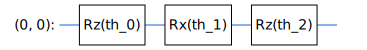

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.1760
Epoch 2/10
1/1 [==============================] - 1s 648ms/sample - loss: 15.1784
Epoch 3/10
1/1 [==============================] - 0s 450ms/sample - loss: 15.1756
Epoch 4/10
1/1 [==============================] - 1s 642ms/sample - loss: 15.1753
Epoch 5/10
1/1 [==============================] - 0s 454ms/sample - loss: 15.1765
Epoch 6/10
1/1 [==============================] - 0s 421ms/sample - loss: 15.1760
Epoch 7/10
1/1 [==============================] - 0s 482ms/sample - loss: 15.1750
Epoch 8/10
1/1 [==============================] - 0s 479ms/sample - loss: 15.1752
Epoch 9/10
1/1 [==============================] - 0s 495ms/sample - loss: 15.1758
Epoch 10/10
1/1 [==============================] - 0s 476ms/sample - loss: 15.1757
2:


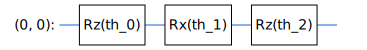

 10%|█         | 1/10 [00:06<00:55,  6.18s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  1
1:


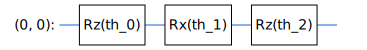

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.1768
Epoch 2/10
1/1 [==============================] - 1s 628ms/sample - loss: 15.1768
Epoch 3/10
1/1 [==============================] - 0s 450ms/sample - loss: 15.1764
Epoch 4/10
1/1 [==============================] - 0s 452ms/sample - loss: 15.1750
Epoch 5/10
1/1 [==============================] - 0s 419ms/sample - loss: 15.1753
Epoch 6/10
1/1 [==============================] - 0s 456ms/sample - loss: 15.1758
Epoch 7/10
1/1 [==============================] - 0s 470ms/sample - loss: 15.1756
Epoch 8/10
1/1 [==============================] - 1s 559ms/sample - loss: 15.1752
Epoch 9/10
1/1 [==============================] - 0s 470ms/sample - loss: 15.1750
Epoch 10/10
1/1 [==============================] - 0s 471ms/sample - loss: 15.1750
2:


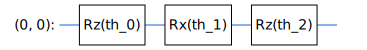

 20%|██        | 2/10 [00:12<00:48,  6.09s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  2
1:


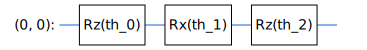

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.4987
Epoch 2/10
1/1 [==============================] - 1s 566ms/sample - loss: 15.4806
Epoch 3/10
1/1 [==============================] - 1s 755ms/sample - loss: 15.4595
Epoch 4/10
1/1 [==============================] - 1s 695ms/sample - loss: 15.4494
Epoch 5/10
1/1 [==============================] - 1s 662ms/sample - loss: 15.4491
Epoch 6/10
1/1 [==============================] - 1s 535ms/sample - loss: 15.4474
Epoch 7/10
1/1 [==============================] - 1s 701ms/sample - loss: 15.4419
Epoch 8/10
1/1 [==============================] - 1s 529ms/sample - loss: 15.4331
Epoch 9/10
1/1 [==============================] - 1s 790ms/sample - loss: 15.4218
Epoch 10/10
1/1 [==============================] - 1s 796ms/sample - loss: 15.4090
2:


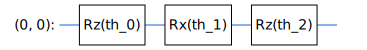

 30%|███       | 3/10 [00:19<00:45,  6.55s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  3
1:


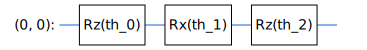

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.5244
Epoch 2/10
1/1 [==============================] - 1s 592ms/sample - loss: 15.5082
Epoch 3/10
1/1 [==============================] - 1s 808ms/sample - loss: 15.5031
Epoch 4/10
1/1 [==============================] - 1s 803ms/sample - loss: 15.4931
Epoch 5/10
1/1 [==============================] - 1s 607ms/sample - loss: 15.4787
Epoch 6/10
1/1 [==============================] - 1s 563ms/sample - loss: 15.4619
Epoch 7/10
1/1 [==============================] - 1s 768ms/sample - loss: 15.4483
Epoch 8/10
1/1 [==============================] - 1s 575ms/sample - loss: 15.4439
Epoch 9/10
1/1 [==============================] - 1s 782ms/sample - loss: 15.4483
Epoch 10/10
1/1 [==============================] - 1s 603ms/sample - loss: 15.4526
2:


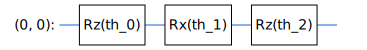

 40%|████      | 4/10 [00:27<00:41,  6.87s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  4
1:


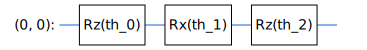

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.1750
Epoch 2/10
1/1 [==============================] - 0s 479ms/sample - loss: 15.1816
Epoch 3/10
1/1 [==============================] - 0s 483ms/sample - loss: 15.1754
Epoch 4/10
1/1 [==============================] - 0s 497ms/sample - loss: 15.1764
Epoch 5/10
1/1 [==============================] - 0s 474ms/sample - loss: 15.1787
Epoch 6/10
1/1 [==============================] - 1s 567ms/sample - loss: 15.1775
2:


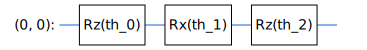

 50%|█████     | 5/10 [00:31<00:29,  6.00s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  5
1:


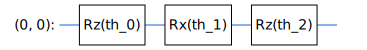

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.1763
Epoch 2/10
1/1 [==============================] - 0s 481ms/sample - loss: 15.1775
Epoch 3/10
1/1 [==============================] - 0s 446ms/sample - loss: 15.1760
Epoch 4/10
1/1 [==============================] - 0s 489ms/sample - loss: 15.1750
Epoch 5/10
1/1 [==============================] - 0s 446ms/sample - loss: 15.1758
Epoch 6/10
1/1 [==============================] - 1s 508ms/sample - loss: 15.1760
Epoch 7/10
1/1 [==============================] - 0s 493ms/sample - loss: 15.1754
Epoch 8/10
1/1 [==============================] - 0s 484ms/sample - loss: 15.1750
Epoch 9/10
1/1 [==============================] - 0s 496ms/sample - loss: 15.1750
2:


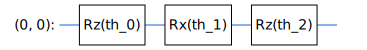

 60%|██████    | 6/10 [00:36<00:23,  5.82s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  6
1:


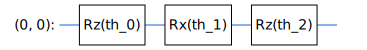

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.1750
Epoch 2/10
1/1 [==============================] - 0s 432ms/sample - loss: 15.1820
Epoch 3/10
1/1 [==============================] - 0s 481ms/sample - loss: 15.1754
Epoch 4/10
1/1 [==============================] - 0s 450ms/sample - loss: 15.1765
Epoch 5/10
1/1 [==============================] - 0s 491ms/sample - loss: 15.1788
Epoch 6/10
1/1 [==============================] - 0s 493ms/sample - loss: 15.1778
2:


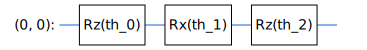

 70%|███████   | 7/10 [00:40<00:15,  5.22s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  7
1:


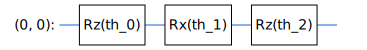

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.1760
Epoch 2/10
1/1 [==============================] - 0s 459ms/sample - loss: 15.1778
Epoch 3/10
1/1 [==============================] - 0s 444ms/sample - loss: 15.1757
Epoch 4/10
1/1 [==============================] - 0s 476ms/sample - loss: 15.1750
Epoch 5/10
1/1 [==============================] - 0s 436ms/sample - loss: 15.1760
Epoch 6/10
1/1 [==============================] - 0s 494ms/sample - loss: 15.1760
Epoch 7/10
1/1 [==============================] - 1s 509ms/sample - loss: 15.1753
Epoch 8/10
1/1 [==============================] - 1s 515ms/sample - loss: 15.1750
Epoch 9/10
1/1 [==============================] - 0s 479ms/sample - loss: 15.1750
Epoch 10/10
1/1 [==============================] - 0s 495ms/sample - loss: 15.1752
2:


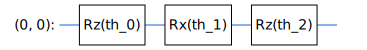

 80%|████████  | 8/10 [00:46<00:10,  5.49s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  8
1:


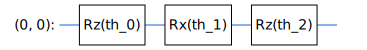

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 14.7535
Epoch 2/10
1/1 [==============================] - 0s 377ms/sample - loss: 14.7525
Epoch 3/10
1/1 [==============================] - 0s 475ms/sample - loss: 14.7527
Epoch 4/10
1/1 [==============================] - 0s 453ms/sample - loss: 14.7525
Epoch 5/10
1/1 [==============================] - 0s 452ms/sample - loss: 14.7519
Epoch 6/10
1/1 [==============================] - 0s 381ms/sample - loss: 14.7513
Epoch 7/10
1/1 [==============================] - 0s 450ms/sample - loss: 14.7517
Epoch 8/10
1/1 [==============================] - 0s 490ms/sample - loss: 14.7521
Epoch 9/10
1/1 [==============================] - 0s 361ms/sample - loss: 14.7519
Epoch 10/10
1/1 [==============================] - 0s 329ms/sample - loss: 14.7513
2:


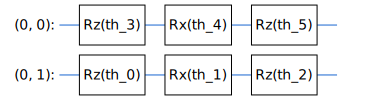

 90%|█████████ | 9/10 [00:51<00:05,  5.41s/it]

accepted
about to simplify

%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  9
1:


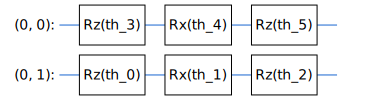

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 15.1763
Epoch 2/10
1/1 [==============================] - 1s 610ms/sample - loss: 15.1795
Epoch 3/10
1/1 [==============================] - 1s 720ms/sample - loss: 15.1762
Epoch 4/10
1/1 [==============================] - 1s 630ms/sample - loss: 15.1755
Epoch 5/10
1/1 [==============================] - 1s 641ms/sample - loss: 15.1767
Epoch 6/10
1/1 [==============================] - 1s 686ms/sample - loss: 15.1767
Epoch 7/10
1/1 [==============================] - 1s 680ms/sample - loss: 15.1756
Epoch 8/10
1/1 [==============================] - 1s 772ms/sample - loss: 15.1750
Epoch 9/10
1/1 [==============================] - 1s 620ms/sample - loss: 15.1753
Epoch 10/10
1/1 [==============================] - 1s 549ms/sample - loss: 15.1757
2:


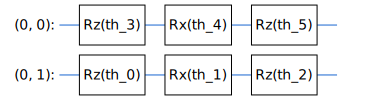

100%|██████████| 10/10 [00:59<00:00,  5.95s/it]

[array(-0.6508051, dtype=float32), array(-0.6508051, dtype=float32), array(-0.6508051, dtype=float32), array(-0.6508051, dtype=float32), array(-0.6508051, dtype=float32), array(-0.6508051, dtype=float32), array(-0.6508051, dtype=float32), array(-0.6508051, dtype=float32), array(-0.6509583, dtype=float32), array(-0.6509583, dtype=float32)]
dep 0.01
about to fit!
Train on 1 samples
Epoch 1/10


1/1 [==============================] - 1s 910ms/sample - loss: 14.1944
Epoch 2/10
1/1 [==============================] - 0s 363ms/sample - loss: 14.1972
Epoch 3/10
1/1 [==============================] - 0s 329ms/sample - loss: 14.1945
Epoch 4/10
1/1 [==============================] - 0s 342ms/sample - loss: 14.1948
Epoch 5/10
1/1 [==============================] - 0s 335ms/sample - loss: 14.1958
Epoch 6/10
1/1 [==============================] - 0s 455ms/sample - loss: 14.1952


  0%|          | 0/10 [00:00<?, ?it/s]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  0
1:


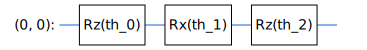

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 14.1980
Epoch 2/10
1/1 [==============================] - 0s 326ms/sample - loss: 14.1973
Epoch 3/10
1/1 [==============================] - 0s 459ms/sample - loss: 14.1965
Epoch 4/10
1/1 [==============================] - 1s 537ms/sample - loss: 14.1967
Epoch 5/10
1/1 [==============================] - 0s 334ms/sample - loss: 14.1965
Epoch 6/10
1/1 [==============================] - 0s 452ms/sample - loss: 14.1954
Epoch 7/10
1/1 [==============================] - 0s 381ms/sample - loss: 14.1950
Epoch 8/10
1/1 [==============================] - 0s 446ms/sample - loss: 14.1954
Epoch 9/10
1/1 [==============================] - 1s 506ms/sample - loss: 14.1958
Epoch 10/10
1/1 [==============================] - 1s 511ms/sample - loss: 14.1955
2:


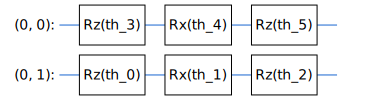

 10%|█         | 1/10 [00:05<00:48,  5.35s/it]

accepted
about to simplify

%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  1
1:


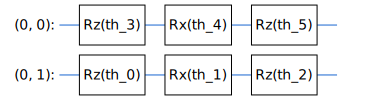

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 14.2621
Epoch 2/10
1/1 [==============================] - 1s 626ms/sample - loss: 14.2749
Epoch 3/10
1/1 [==============================] - 0s 499ms/sample - loss: 14.2626
Epoch 4/10
1/1 [==============================] - 1s 535ms/sample - loss: 14.2632
Epoch 5/10
1/1 [==============================] - 1s 566ms/sample - loss: 14.2660
Epoch 6/10
1/1 [==============================] - 1s 662ms/sample - loss: 14.2641
2:


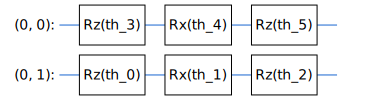

 20%|██        | 2/10 [00:09<00:40,  5.08s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  2
1:


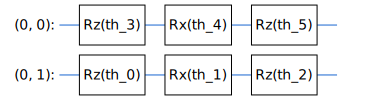

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 1s 1s/sample - loss: 14.2623
Epoch 2/10
1/1 [==============================] - 0s 495ms/sample - loss: 14.2735
Epoch 3/10
1/1 [==============================] - 1s 576ms/sample - loss: 14.2624
Epoch 4/10
1/1 [==============================] - 1s 752ms/sample - loss: 14.2632
Epoch 5/10
1/1 [==============================] - 1s 828ms/sample - loss: 14.2658
Epoch 6/10
1/1 [==============================] - 1s 710ms/sample - loss: 14.2641
2:


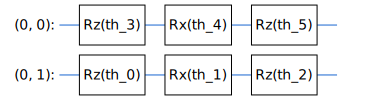

 30%|███       | 3/10 [00:14<00:35,  5.09s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  3
1:


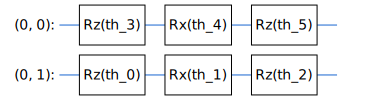

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 2s 2s/sample - loss: 14.4255
Epoch 2/10
1/1 [==============================] - 1s 899ms/sample - loss: 14.3571
Epoch 3/10
1/1 [==============================] - 1s 922ms/sample - loss: 14.3956
Epoch 4/10
1/1 [==============================] - 1s 917ms/sample - loss: 14.3834
Epoch 5/10
1/1 [==============================] - 1s 916ms/sample - loss: 14.3517
Epoch 6/10
1/1 [==============================] - 1s 738ms/sample - loss: 14.3308
Epoch 7/10
1/1 [==============================] - 1s 873ms/sample - loss: 14.3055
Epoch 8/10
1/1 [==============================] - 1s 723ms/sample - loss: 14.2331
Epoch 9/10
1/1 [==============================] - 1s 1s/sample - loss: 14.0953
Epoch 10/10
1/1 [==============================] - 1s 881ms/sample - loss: 13.9096
2:


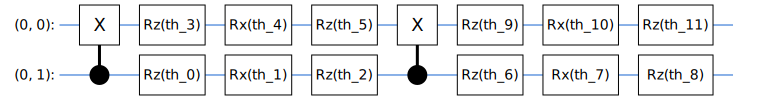

accepted
3: 


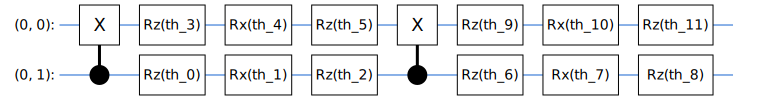

3: 


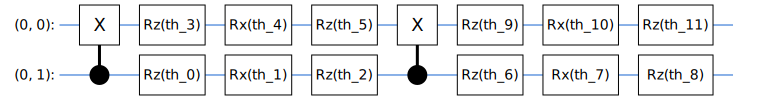

3: 


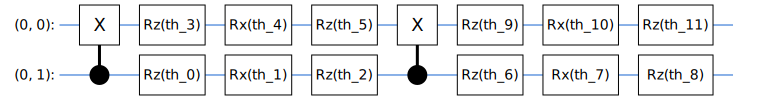

3: 


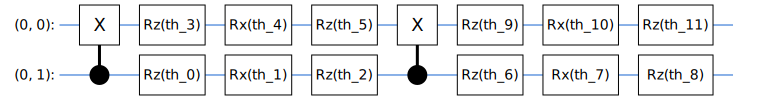

3: 


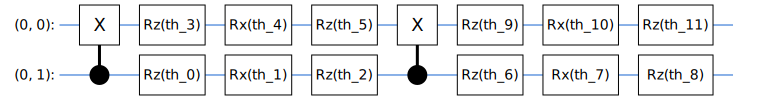

3: 


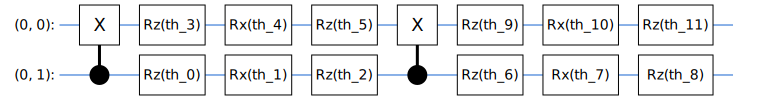

3: 


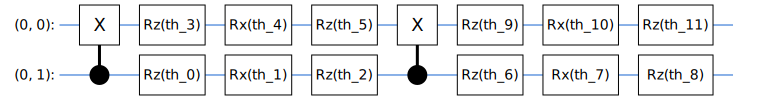

3: 


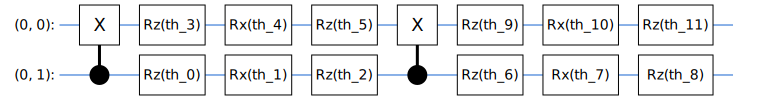

3: 


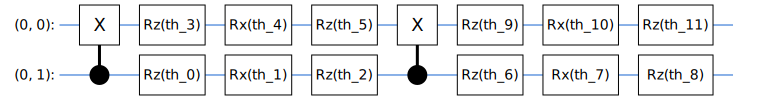

3: 


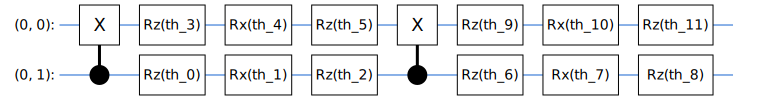

about to simplify
actually simplified!: running opt
about to fit!
Train on 1 samples
Epoch 1/200
1/1 [==============================] - 1s 992ms/sample - loss: 14.3435
Epoch 2/200
1/1 [==============================] - 1s 587ms/sample - loss: 14.3338
Epoch 3/200
1/1 [==============================] - 1s 603ms/sample - loss: 14.3258
Epoch 4/200
1/1 [==============================] - 1s 693ms/sample - loss: 14.3196
Epoch 5/200
1/1 [==============================] - 1s 550ms/sample - loss: 14.3149
Epoch 6/200
1/1 [==============================] - 1s 557ms/sample - loss: 14.3115
Epoch 7/200
1/1 [==============================] - 1s 600ms/sample - loss: 14.3090
Epoch 8/200
1/1 [==============================] - 1s 782ms/sample - loss: 14.3071
Epoch 9/200
1/1 [==============================] - 1s 580ms/sample - loss: 14.3053
Epoch 10/200
1/1 [==============================] - 1s 661ms/sample - loss: 14.3032
Epoch 11/200
1/1 [==============================] - 1s 600ms/sample - loss: 14.3005


Epoch 98/200
1/1 [==============================] - 1s 650ms/sample - loss: 13.4170
Epoch 99/200
1/1 [==============================] - 1s 587ms/sample - loss: 13.4168
Epoch 100/200
1/1 [==============================] - 1s 720ms/sample - loss: 13.4166
Epoch 101/200
1/1 [==============================] - 1s 707ms/sample - loss: 13.4165
Epoch 102/200
1/1 [==============================] - 1s 828ms/sample - loss: 13.4164
Epoch 103/200
1/1 [==============================] - 1s 962ms/sample - loss: 13.4163
Epoch 104/200
1/1 [==============================] - 1s 819ms/sample - loss: 13.4161
Epoch 105/200
1/1 [==============================] - 1s 755ms/sample - loss: 13.4160
Epoch 106/200
1/1 [==============================] - 1s 666ms/sample - loss: 13.4160
Epoch 107/200
1/1 [==============================] - 0s 496ms/sample - loss: 13.4159
Epoch 108/200
1/1 [==============================] - 1s 587ms/sample - loss: 13.4158
Epoch 109/200
1/1 [==============================] - 1s 611ms/sampl

Epoch 195/200
1/1 [==============================] - 1s 598ms/sample - loss: 13.4039
Epoch 196/200
1/1 [==============================] - 1s 563ms/sample - loss: 13.4037
Epoch 197/200
1/1 [==============================] - 1s 743ms/sample - loss: 13.4035
Epoch 198/200
1/1 [==============================] - 1s 548ms/sample - loss: 13.4034
Epoch 199/200
1/1 [==============================] - 1s 760ms/sample - loss: 13.4032
Epoch 200/200
1/1 [==============================] - 1s 791ms/sample - loss: 13.4030
3:


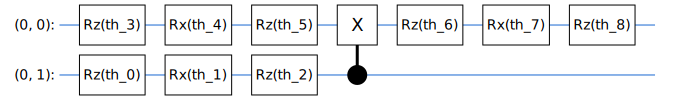

 40%|████      | 4/10 [02:46<04:54, 49.02s/it]


%%%%%%%%%%%%%%%%%%%%%%%%%
new iteration:  4
1:


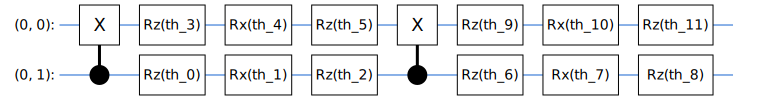

Train on 1 samples
Epoch 1/10
1/1 [==============================] - 2s 2s/sample - loss: 15.0033
Epoch 2/10
1/1 [==============================] - 1s 1s/sample - loss: 14.5693
Epoch 3/10
1/1 [==============================] - 2s 2s/sample - loss: 14.4146
Epoch 4/10
1/1 [==============================] - 1s 1s/sample - loss: 14.3249
Epoch 5/10


In [ ]:
sols = {}
J=1.21
for dep in [0.1,0.01,0.001,0.0001]:
    print("dep", dep)
    sol = Solver(n_qubits= 4, qlr=0.1, qepochs=10, g=1, J=J, noises={"depolarizing":dep}, verbose=1)
    sol.history_circuits=[]
    history_energies=[]
    best_energies_found = []

    gates_index = [sol.number_of_cnots] ## begin with a certain circuit
    gates_index, resolver, energy= sol.run_circuit_from_index(gates_index)
    sol.history_circuits.append(gates_index)
#    sol.current_circuit = gates_index

    for kk in tqdm(range(10)):
        print("\n%%%%%%%%%%%%%%%%%%%%%%%%%")
        print("new iteration: ",kk)
        print("1:" )
        display(SVGCircuit(sol.give_circuit(gates_index)[0]))
        
        enns = [energy]
        which_block = np.random.choice([0,1], p=[.5,.5])
        if which_block == 0:
            qubit = np.random.choice(sol.n_qubits)
            block_to_insert = sol.resolution_1qubit(qubit)
            insertion_index = np.random.choice(max(1,len(gates_index))) #gives index between \in [0, len(gates_index) )
        else:
            qubits = np.random.choice(sol.n_qubits, 2,replace = False)
            block_to_insert = sol.resolution_2cnots(qubits[0], qubits[1])
            insertion_index = np.random.choice(max(1,len(gates_index))) #gives index between \in [0, len(gates_index) )
        
        #print(block_to_insert)
        ### optimize the circuit with the block appended. This is tricky since we initialize
        ###  the continuous parameters with the older ones, and the "block ones" close to identity
        circuit, variables = sol.prepare_circuit_insertion(gates_index, block_to_insert, insertion_index) #this either accepts or reject the insertion
        model = sol.initialize_model_insertion(variables) ### initialize the model in the previously optimized parameters & resolution to identity for the block

        gates_index, resolver, energy, accepted = sol.optimize_and_update(gates_index,model, circuit, variables, insertion_index) #inside, if better circuit is found, saves it.
        print("2:")
        display(SVGCircuit(sol.give_circuit(gates_index)[0]))
        if accepted:
            print("accepted")
            sol.history_circuits.append(gates_index)
            #### try to kill one qubit unitaries ###
            for k in range(10):
                if len(gates_index)-sol.count_number_cnots(gates_index) > 2:
                    gates_index, resolver, energy, simplified =  sol.kill_one_unitary(gates_index, resolver, energy)
                    print("3: ")
                    display(SVGCircuit(sol.give_circuit(gates_index)[0]))
                    sol.history_circuits.append(gates_index)
                    
            ### simplify the circuit and if the length is changed I run the optimization again
            print("about to simplify")
            simplified_gates_index = sol.simplify_circuit(gates_index)
            if len(simplified_gates_index)<len(gates_index) and len(simplified_gates_index)>0:
                print("actually simplified!: running opt")
                ggates_index, rresolver, eenergy = sol.run_circuit_from_index(simplified_gates_index,hyperparameters=[200,0.01]) #here I don't save the resolver since it's a mess
                print("3:")
                display(SVGCircuit(sol.give_circuit(ggates_index)[0]))
                
                if energy < sol.lowest_energy_found:
                    sol.lowest_energy_found = energy
                    sol.best_circuit_found = gates_index
                    sol.best_resolver_found = resolver
                    gates_index = ggates_index
                    sol.history_circuits.append(gates_index)
                    resolver = resolver
                    energy = eenergy
        
        sol.new_resolver = {}
        history_energies.append(sol.lowest_energy_found)
        enns=[]
        #print("energy: ", energy, "... j", j)
    sol.history_energies=history_energies
    sols[str(dep)] = sol
    print(history_energies)
    
import os
import pickle
os.system("mkdir noise_test")
for k,v in sols.items():
    with open("noise_test/"+k+'.pickle', 'wb') as handle:
        pickle.dump(v, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sol.

In [ ]:
[k.count_number_cnots(k.best_circuit_found) for k in sols.values()]

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle(r'$H = -\sum_i^{n=4} \; Z_i - \;J \sum_i^{n=4} X_i X_{i+1}$', size=25)
ax1 = plt.subplot2grid((1,2),(0,0))
ax2= plt.subplot2grid((1,2),(0,1))

ax1.set_ylabel("Lowest energy found", size=20)
ax1.set_xlabel("J", size=20)

js = np.arange(.01,4.1,.4)
ax1.scatter(js,[k.lowest_energy_found for k in sols.values()], marker="*",alpha=.75, s=80, c="blue",label="Lowest energy found after 15 its")
ax1.scatter(js,np.loadtxt("Ising4q.csv"), alpha=.5, s=80, c="red",label="Ground state")
ax1.legend(prop={"size":20})
#plt.xticks(js, size=30)

ax2.scatter(js, [k.count_number_cnots(k.best_circuit_found) for k in sols.values()], alpha=1, s=100)
ax2.set_xlabel("J")
ax2.set_yticks([k.count_number_cnots(k.best_circuit_found) for k in sols.values()])
ax2.set_ylabel("Number of CNOTs", size=20)
plt.savefig("ising_larger_interactions.png")

In [ ]:
list(sols.items())

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle(r'$H = -\sum_i^{4} \; S^{z}_i - \;J \; \sum_i^{4} \; S^{x}_i S^{x}_{i+1}$', size=25)
ax1 = plt.subplot2grid((1,1),(0,0))
#ax2= plt.subplot2grid((1,2),(0,1))

ax1.set_ylabel(r'$\frac{\Delta E}{E_{ground}}$', size=45)#(r'$|E_{lowest}- E_{ground}|$', size=30)
ax1.set_xlabel(r'$E_{ground}$', size=45)

enns = np.array(np.loadtxt("Ising4q.csv"))
js = np.arange(.01,4.1,.4)
ax1.scatter(np.abs(enns),np.abs(np.array([k.lowest_energy_found for k in sols.values()]) - enns)/np.abs(enns), marker="o",alpha=.6, s=300, c="red",label=r'$\Delta E/E_ground$')
#ax1.scatter(js,, alpha=.5, s=80, c="red",label="Ground state")
#ax1.legend(prop={"size":20})
#plt.xticks(js, size=30)
ticks=[]
for k,i in enumerate(np.abs(enns)):
    if k!=1:
        ticks.append(np.round(i,2))
ax1.set_xticks(ticks)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax2.scatter(js, [k.count_number_cnots(k.best_circuit_found) for k in sols.values()], alpha=1, s=100)
#ax2.set_xlabel("J")
#ax2.set_yticks([k.count_number_cnots(k.best_circuit_found) for k in sols.values()])
#ax2.set_ylabel("Number of CNOTs", size=20)
plt.savefig("energies_4ising.png")

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle(r'$H = -\sum_i^{4} \; S^{z}_i - \;J \; \sum_i^{4} \; S^{x}_i S^{x}_{i+1}$', size=25)
ax1 = plt.subplot2grid((1,1),(0,0))
#ax2= plt.subplot2grid((1,2),(0,1))

ax1.set_ylabel(r'$\Delta E$', size=45)#(r'$|E_{lowest}- E_{ground}|$', size=30)
ax1.set_xlabel(r'$E_{ground}$', size=45)

enns = np.array(np.loadtxt("Ising4q.csv"))
js = np.arange(.01,4.1,.4)
ax1.scatter(np.abs(enns),np.abs(np.array([k.lowest_energy_found for k in sols.values()]) - enns), marker="*",alpha=.6, s=180, c="blue",label=r'$\Delta E$')
#ax1.scatter(js,, alpha=.5, s=80, c="red",label="Ground state")
#ax1.legend(prop={"size":20})
#plt.xticks(js, size=30)
ticks=[]
for k,i in enumerate(np.abs(enns)):
    if k!=1:
        ticks.append(np.round(i,2))
ax1.set_xticks(ticks)
ax1.tick_params(axis='both', which='major', labelsize=20)
#ax2.scatter(js, [k.count_number_cnots(k.best_circuit_found) for k in sols.values()], alpha=1, s=100)
#ax2.set_xlabel("J")
#ax2.set_yticks([k.count_number_cnots(k.best_circuit_found) for k in sols.values()])
#ax2.set_ylabel("Number of CNOTs", size=20)
#plt.savefig("energies.png")